In [19]:
pip install circe-py

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import circe as ci
import circe.metacells as circe_metacells
import scanpy as sc
import scipy as sp

# Test with sparse covariance true matrix as GT

### 0. Create fake AnnData

This data doesn't contain strong correlation between fake regions, the score will then be low. 

It will still allow us to demonstrate how to use Circe. :)

In [3]:
atac = sc.datasets.blobs(n_centers=10, n_variables=2_000, n_observations=300, random_state=0)
atac.X = np.random.poisson(lam=1, size=atac.X.shape)
cell_names = [f"cell_{i}" for i in range(1, atac.shape[0]+1)]
# number of chr_start_end region names
region_names = [[f"chr{i}_{str(j)}_{str(j+150)}" 
                 for j in range(1, 10000*400+1, 10000)] 
                for i in range(1, 6)]
regions_names = [item for sublist in region_names for item in sublist]
atac.var_names = regions_names
atac.obs_names = cell_names

In [4]:
distance_threshold = 250_000

### 1. Add region position in AnnData.obs

In [5]:
atac = ci.add_region_infos(atac)

### 2. Replace random data with fake cov matrix

### 2.A. Remove Null rows

In [6]:
sc.pp.filter_genes(atac, min_cells=1,)
sc.pp.filter_cells(atac, min_genes=1,)
atac

/home/rtrimbou/miniconda3/envs/test_circe_pip/lib/python3.12/site-packages/scanpy/preprocessing/_simple.py:282: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


AnnData object with n_obs × n_vars = 300 × 2000
    obs: 'blobs', 'n_genes'
    var: 'chromosome', 'start', 'end', 'n_cells'

### 2.B. Compute pseudocells

In [7]:
metacells = circe_metacells.compute_metacells(atac)

Output()

### 3 Calculate co-accessibility

In [9]:
ci.compute_atac_network(
    atac, #metacells,
    window_size=distance_threshold,
    unit_distance = 1000,
    distance_constraint=distance_threshold/2,
    n_samples=50,
    n_samples_maxtry=100,
    max_alpha_iteration=100
)

Output()

Output()

Output()

Averaging co-accessibility scores across windows...
Done !


*1. Circe can also work with sparse covariance matrix.*<br>
*2. Connections can also be stored externally using 'sliding_graphical_lasso'.*

In [10]:
atac.X = sp.sparse.csr_matrix(atac.X)
# atac.X = atac.X.toarray()

In [11]:
final_score = ci.sliding_graphical_lasso(
    atac,
    window_size=distance_threshold,
    unit_distance = 1000,
    distance_constraint=distance_threshold/2,
    n_samples=50,
    n_samples_maxtry=100,
    max_alpha_iteration=500
)
atac.varp['atac_network'] = final_score

Output()

Output()

Output()

Averaging co-accessibility scores across windows...
Done !


### 3. B. Extract list of edges

In [12]:
circe_network = ci.extract_atac_links(atac) #metacells)
circe_network

,Peak1,Peak2,score
304,chr1_1130001_1130151,chr1_1360001_1360151,0.131203
7765,chr5_2680001_2680151,chr5_2810001_2810151,0.120076
3535,chr3_540001_540151,chr3_640001_640151,0.117660
551,chr1_1580001_1580151,chr1_1620001_1620151,0.098067
7360,chr5_1620001_1620151,chr5_1740001_1740151,0.098064
...,...,...,...
5341,chr4_940001_940151,chr4_1060001_1060151,-0.100063
5230,chr4_300001_300151,chr4_460001_460151,-0.102714
5564,chr4_1880001_1880151,chr4_2000001_2000151,-0.105041
4980,chr3_3440001_3440151,chr3_3450001_3450151,-0.109209


### 4. Plot co-accessibility scores in a window

0.05506910617832078


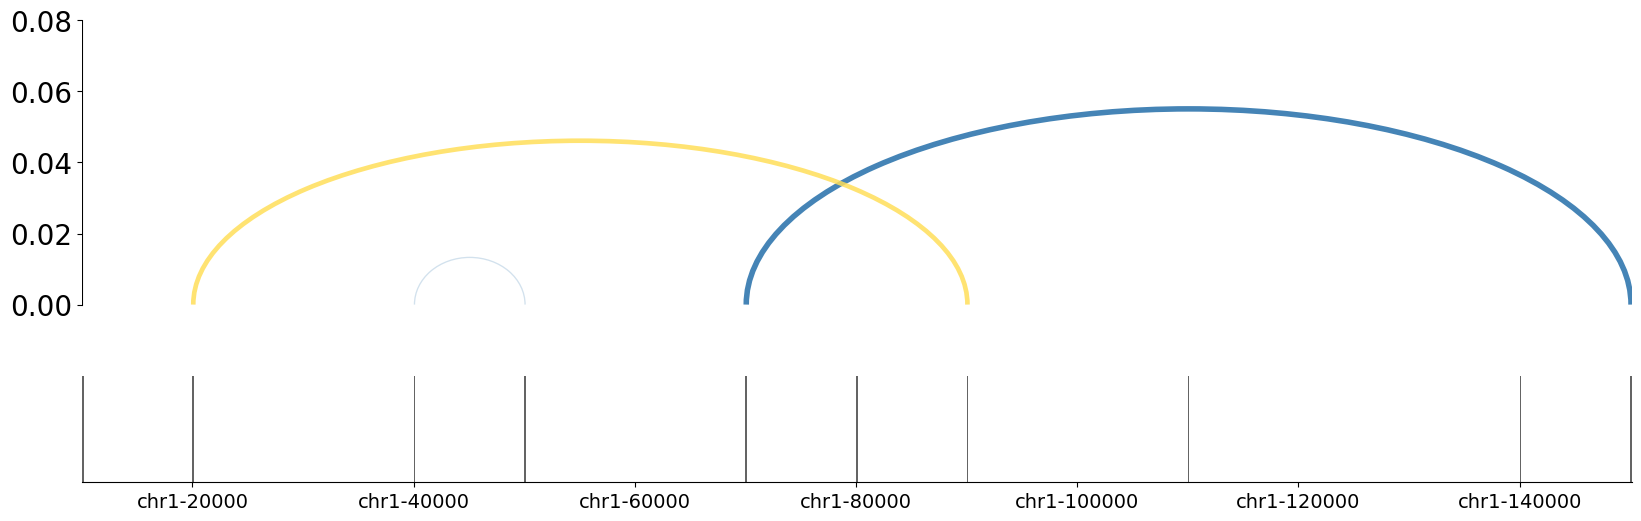

In [15]:
ci.plot_connections(
    circe_network,
    chromosome="chr1",
    start=10_000,
    end=200_000,
    sep=("_","_"),
    abs_threshold=0.01
)

In [16]:
atac2 = ci.subset_region(atac, "chr1", 10_000, 100_000)

In [17]:
df = ci.extract_atac_links(atac2)
df

/home/rtrimbou/miniconda3/envs/test_circe_pip/lib/python3.12/site-packages/circe/circe.py:288: ImplicitModificationWarning: Setting element `.varp['atac_network']` of view, initializing view as actual.
  anndata.varp[key] = anndata.varp[key].tocoo()


,Peak1,Peak2,score
3,chr1_40001_40151,chr1_50001_50151,1.327766e-02
4,chr1_70001_70151,chr1_80001_80151,6.105672e-03
0,chr1_10001_10151,chr1_40001_40151,-7.513865e-08
1,chr1_10001_10151,chr1_50001_50151,-5.659026e-06
2,chr1_20001_20151,chr1_90001_90151,-4.610871e-02


In [18]:
circe_network

,Peak1,Peak2,score
304,chr1_1130001_1130151,chr1_1360001_1360151,0.131203
7765,chr5_2680001_2680151,chr5_2810001_2810151,0.120076
3535,chr3_540001_540151,chr3_640001_640151,0.117660
551,chr1_1580001_1580151,chr1_1620001_1620151,0.098067
7360,chr5_1620001_1620151,chr5_1740001_1740151,0.098064
...,...,...,...
5341,chr4_940001_940151,chr4_1060001_1060151,-0.100063
5230,chr4_300001_300151,chr4_460001_460151,-0.102714
5564,chr4_1880001_1880151,chr4_2000001_2000151,-0.105041
4980,chr3_3440001_3440151,chr3_3450001_3450151,-0.109209


In [23]:
from rich.progress import Progress

In [25]:
?Progress

Init signature:
Progress(
    *columns: Union[str, rich.progress.ProgressColumn],
    console: Optional[rich.console.Console] = None,
    auto_refresh: bool = True,
    refresh_per_second: float = 10,
    speed_estimate_period: float = 30.0,
    transient: bool = False,
    redirect_stdout: bool = True,
    redirect_stderr: bool = True,
    get_time: Optional[Callable[[], float]] = None,
    disable: bool = False,
    expand: bool = False,
) -> None
Docstring:     
Renders an auto-updating progress bar(s).

Args:
    console (Console, optional): Optional Console instance. Default will an internal Console instance writing to stdout.
    auto_refresh (bool, optional): Enable auto refresh. If disabled, you will need to call `refresh()`.
    refresh_per_second (Optional[float], optional): Number of times per second to refresh the progress information or None to use default (10). Defaults to None.
    speed_estimate_period: (float, optional): Period (in seconds) used to calculate the speed 

In [26]:
?Progress.add_task

Signature:
Progress.add_task(
    self,
    description: str,
    start: bool = True,
    total: float = 100.0,
    completed: int = 0,
    visible: bool = True,
    **fields: Any,
) -> rich.progress.TaskID
Docstring:
Add a new 'task' to the Progress display.

Args:
    description (str): A description of the task.
    start (bool, optional): Start the task immediately (to calculate elapsed time). If set to False,
        you will need to call `start` manually. Defaults to True.
    total (float, optional): Number of total steps in the progress if know. Defaults to 100.
    completed (int, optional): Number of steps completed so far.. Defaults to 0.
    visible (bool, optional): Enable display of the task. Defaults to True.
    **fields (str): Additional data fields required for rendering.

Returns:
    TaskID: An ID you can use when calling `update`.
File:      ~/miniconda3/envs/test_circe_pip/lib/python3.12/site-packages/rich/progress.py
Type:      function

In [27]:
import rich.progress

In [29]:
?rich.progress.TaskID

Signature:   rich.progress.TaskID(x, /)
Type:        NewType
String form: rich.progress.TaskID
File:        ~/miniconda3/envs/test_circe_pip/lib/python3.12/typing.py
Docstring:  
NewType creates simple unique types with almost zero runtime overhead.

NewType(name, tp) is considered a subtype of tp
by static type checkers. At runtime, NewType(name, tp) returns
a dummy callable that simply returns its argument.

Usage::

    UserId = NewType('UserId', int)

    def name_by_id(user_id: UserId) -> str:
        ...

    UserId('user')          # Fails type check

    name_by_id(42)          # Fails type check
    name_by_id(UserId(42))  # OK

    num = UserId(5) + 1     # type: int